In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

Load the data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/NLP Coursework - Group D/Data/Preprocessed/labelled_data.csv")

In [4]:
df.ground_truth.value_counts()

,count
ground_truth,
positive,11227
negative,581


In [5]:
df['sentiment'] = df['ground_truth'].map({'positive': 1, 'negative': 0})

In [6]:
X_text = df['review_text'].tolist()
y = df['sentiment'].tolist()

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'  # You can use a different BERT model if needed
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to get embeddings for a single review
def get_embedding(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the embeddings from BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS] token's embedding as the sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

# Extract embeddings for all reviews
embeddings = []
for review in X_text:
    embedding = get_embedding(review)
    embeddings.append(embedding)

# Convert embeddings to a DataFrame
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv("/content/drive/MyDrive/NLP Coursework - Group D/Data/Preprocessed/bert_embeddings.csv", index=False)  # Save embeddings to a CSV file

print("BERT embeddings extracted and saved!")


BERT embeddings extracted and saved!


In [7]:
embeddings = np.load("/content/drive/MyDrive/NLP Coursework - Group D/Data/Preprocessed/bert_embeddings.npy")

In [8]:
embeddings

array([[-5.14604338e-02, -1.19496986e-01,  3.63474697e-01, ...,
        -5.13991356e-01,  2.66834557e-01,  7.82496184e-02],
       [-1.78723514e-01,  7.20269307e-02,  2.90963799e-01, ...,
        -6.55212045e-01,  1.94813848e-01,  4.84299332e-01],
       [-3.80094163e-02, -2.42322102e-01,  5.04729271e-01, ...,
        -6.05169117e-01,  3.53996843e-01,  3.52689624e-02],
       ...,
       [-1.66212291e-01,  5.63011542e-02,  5.98318875e-01, ...,
        -5.42743146e-01,  1.37829438e-01,  3.80868614e-01],
       [-4.07652587e-01,  1.62054894e-05,  5.01220047e-01, ...,
        -3.30035448e-01,  2.23091990e-01,  9.08455849e-02],
       [-7.82516375e-02,  6.40920177e-02,  4.75151330e-01, ...,
        -4.86026078e-01,  2.54716903e-01,  1.04985513e-01]], dtype=float32)

In [ ]:
embeddings_filepath = "/content/drive/MyDrive/NLP Coursework - Group D/Data/Preprocessed/bert_embeddings.npy"
# import numpy as np
# np.save(embeddings_filepath, embeddings)

In [9]:
import gc
gc.collect()

11

# Comparing w/ Non-DL Algorithms

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)

In [ ]:


def plot_class_distribution(y, title='Class Distribution'):
    """Plot the distribution of classes in the target variable."""
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y)
    plt.title(title)
    plt.show()

def create_resampling_pipeline(smote_ratio=0.5, undersample_ratio=0.7, random_state=42):
    """Create a resampling pipeline with SMOTE and RandomUnderSampler."""
    return Pipeline([
        ('smote', SMOTE(sampling_strategy=smote_ratio, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=random_state))
    ])

def prepare_training_data(X, y, test_size=0.2, random_state=42):
    """Prepare and resample training data."""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Convert to dense format if using sparse matrices
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    # Scale features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    # Apply resampling
    resampling = create_resampling_pipeline()
    X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)

    return X_train_resampled, X_test, y_train_resampled, y_test

def get_model_params(model_type, y_train=None):
    """Get default parameters for different model types."""
    if model_type == 'xgb':
        return {
            'objective': 'binary:logistic',
            'eval_metric': ['logloss', 'error', 'auc'],
            'max_depth': 6,
            'min_child_weight': 1,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'tree_method': 'hist'
        }
    elif model_type == 'svm':
        return {
            'C': 1.0,
            'kernel': 'rbf',
            'gamma': 'scale',
            'class_weight': 'balanced'
        }
    elif model_type == 'rf':
        return {
            'n_estimators': 100,
            # 'max_depth': 10,
            # 'min_samples_split': 2,
            # 'min_samples_leaf': 1,
            # 'class_weight': 'balanced'
        }
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

def train_model(model_type, X_train, X_test, y_train, y_test, params=None, num_rounds=1000):
    """Train model with early stopping and return model and evaluation results."""
    # Use default params if none provided
    if params is None:
        params = get_model_params(model_type, y_train)

    # Train the model based on type
    if model_type == 'xgb':
        # Create DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Initialize evaluation results dictionary
        evals_result = {}

        # Train XGBoost model
        model = xgb.train(
            params,
            dtrain,
            num_rounds,
            evals=[(dtrain, 'train'), (dtest, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=100,
            evals_result=evals_result
        )

        return model, evals_result

    elif model_type in ['svm', 'rf']:
        # Select the appropriate scikit-learn model
        if model_type == 'svm':
            model = SVC(**params, probability=True)
        else:  # Random Forest
            model = RandomForestClassifier(**params)

        # Fit the model
        model.fit(X_train, y_train)

        # Create a mock evaluation result dictionary to maintain consistency
        evals_result = {
            'train': {
                'logloss': [-np.log(model.predict_proba(X_train)[:, 1]).mean()],
                'error': [1 - model.score(X_train, y_train)],
                'auc': [roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])]
            },
            'eval': {
                'logloss': [-np.log(model.predict_proba(X_test)[:, 1]).mean()],
                'error': [1 - model.score(X_test, y_test)],
                'auc': [roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])]
            }
        }

        return model, evals_result

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

def plot_training_metrics(evals_result):
    """Plot training metrics including loss, error, and AUC."""
    plt.figure(figsize=(15, 5))

    # Plot training and validation log loss
    plt.subplot(1, 3, 1)
    plt.plot(evals_result['train']['logloss'], label='Train')
    plt.plot(evals_result['eval']['logloss'], label='Validation')
    plt.title('Log Loss vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.legend()

    # Plot training and validation error
    plt.subplot(1, 3, 2)
    plt.plot(evals_result['train']['error'], label='Train')
    plt.plot(evals_result['eval']['error'], label='Validation')
    plt.title('Classification Error vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()

    # Plot training and validation AUC
    plt.subplot(1, 3, 3)
    plt.plot(evals_result['train']['auc'], label='Train')
    plt.plot(evals_result['eval']['auc'], label='Validation')
    plt.title('AUC vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, model_type, X_test, y_test):
    """Evaluate the model and plot confusion matrix and ROC curve."""
    # Get predictions based on model type
    if model_type == 'xgb':
        dtest = xgb.DMatrix(X_test)
        y_pred_proba = model.predict(dtest)
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:  # SVM and Random Forest
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return y_pred, y_pred_proba

def train_and_evaluate_model(X, y, model_type='xgb', feature_names=None, custom_params=None):
    """Main function to train and evaluate the model."""
    # Validate model type
    if model_type not in ['xgb', 'svm', 'rf']:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Plot initial class distribution
    plot_class_distribution(y, title='Initial Class Distribution')

    # Prepare data
    X_train_resampled, X_test, y_train_resampled, y_test = prepare_training_data(X, y)

    # Plot resampled class distribution
    plot_class_distribution(y_train_resampled, title='Class Distribution After Resampling')

    # Train model
    model, evals_result = train_model(
        model_type,
        X_train_resampled,
        X_test,
        y_train_resampled,
        y_test,
        params=custom_params
    )

    # Plot training metrics (note: for SVM and RF, this will only show the single point)
    plot_training_metrics(evals_result)

    # Evaluate model
    y_pred, y_pred_proba = evaluate_model(model, model_type, X_test, y_test)

    return model, evals_result

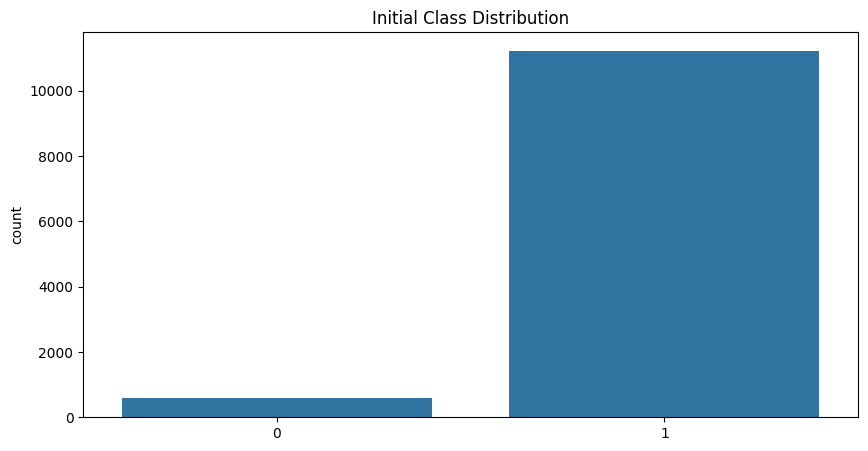

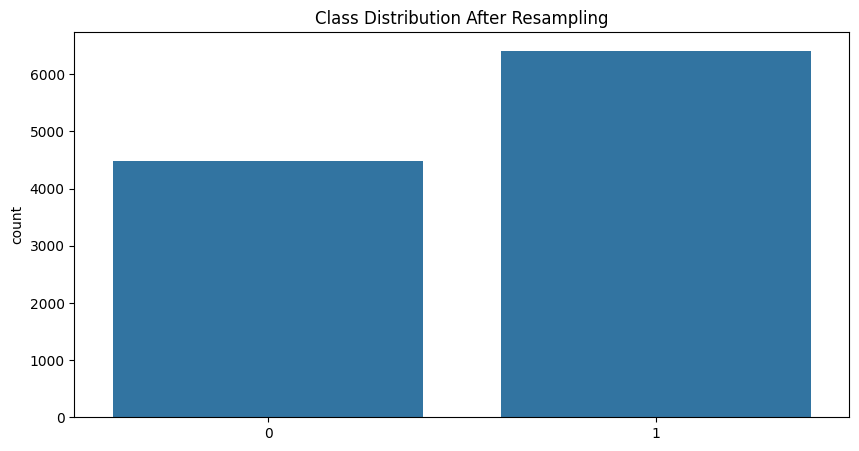

[0]	train-logloss:0.60291	train-error:0.41178	train-auc:0.96283	eval-logloss:0.50142	eval-error:0.04911	eval-auc:0.86333
[100]	train-logloss:0.00670	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09529	eval-error:0.03980	eval-auc:0.97929
[200]	train-logloss:0.00169	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09435	eval-error:0.03641	eval-auc:0.98089
[300]	train-logloss:0.00096	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09471	eval-error:0.03472	eval-auc:0.98185
[400]	train-logloss:0.00070	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09522	eval-error:0.03302	eval-auc:0.98246
[500]	train-logloss:0.00057	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09657	eval-error:0.03302	eval-auc:0.98258
[600]	train-logloss:0.00049	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09763	eval-error:0.03260	eval-auc:0.98291
[700]	train-logloss:0.00044	train-error:0.00000	train-auc:1.00000	eval-logloss:0.09791	eval-error:0.03175	eval-auc:0.98305
[724]	train-loglos

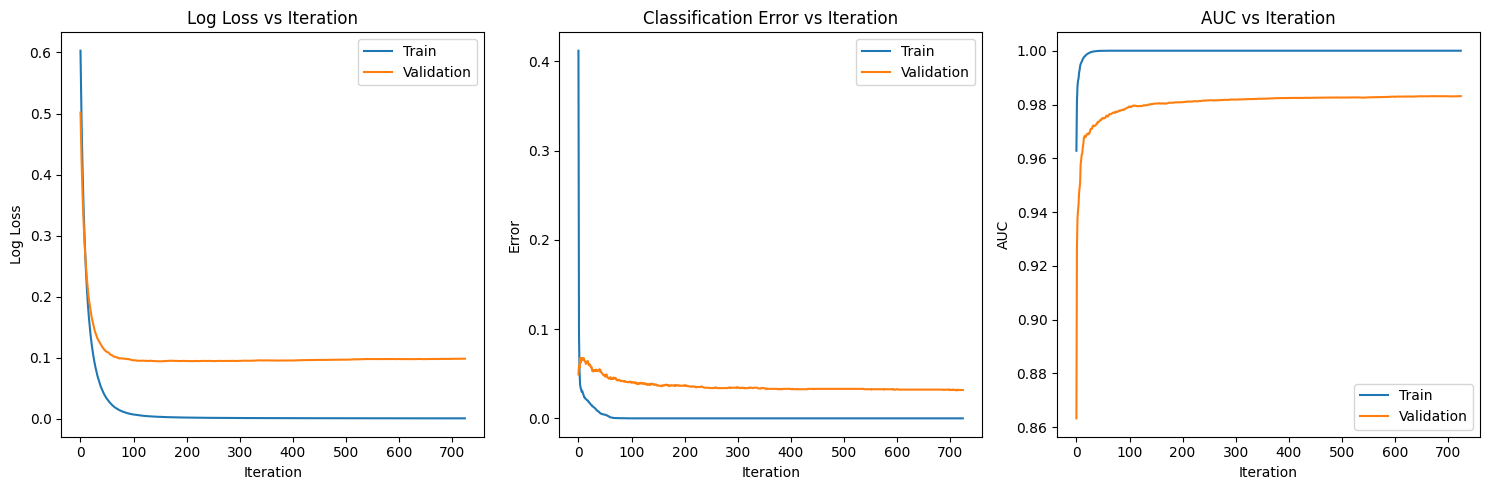

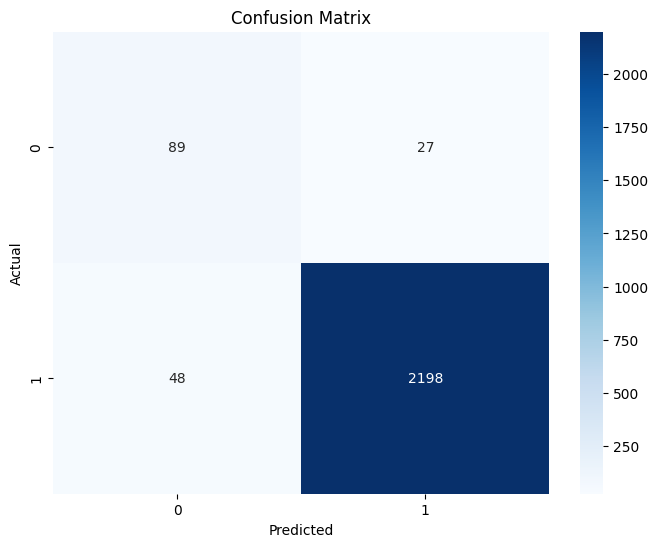

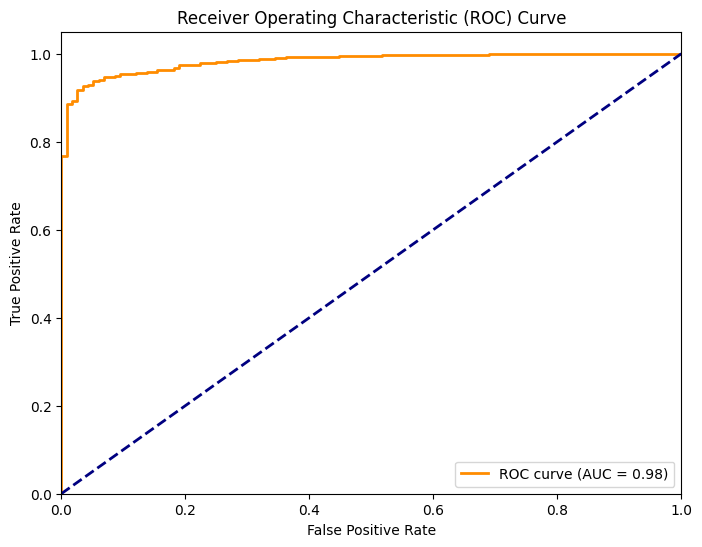


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.70       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.82      0.87      0.84      2362
weighted avg       0.97      0.97      0.97      2362



In [16]:
xgb_model, xgb_results = train_and_evaluate_model(embeddings, y, model_type='xgb')

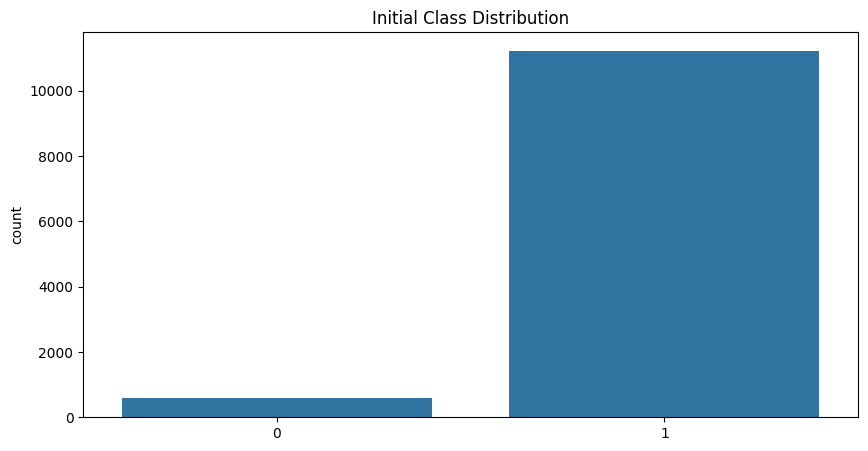

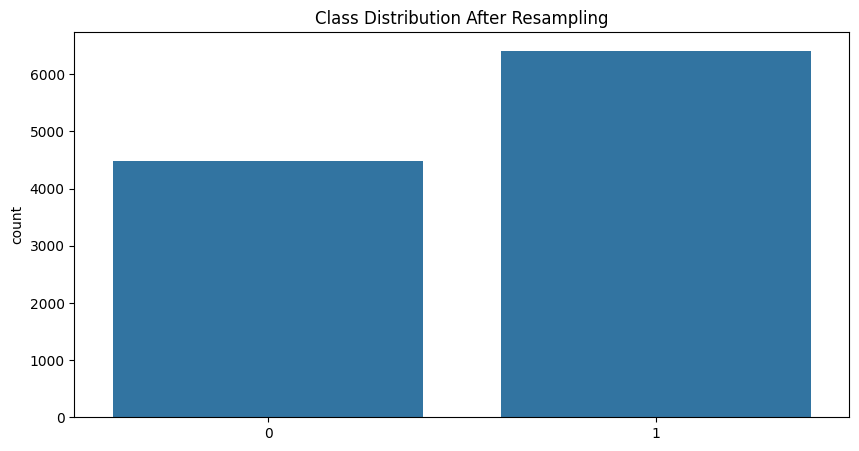

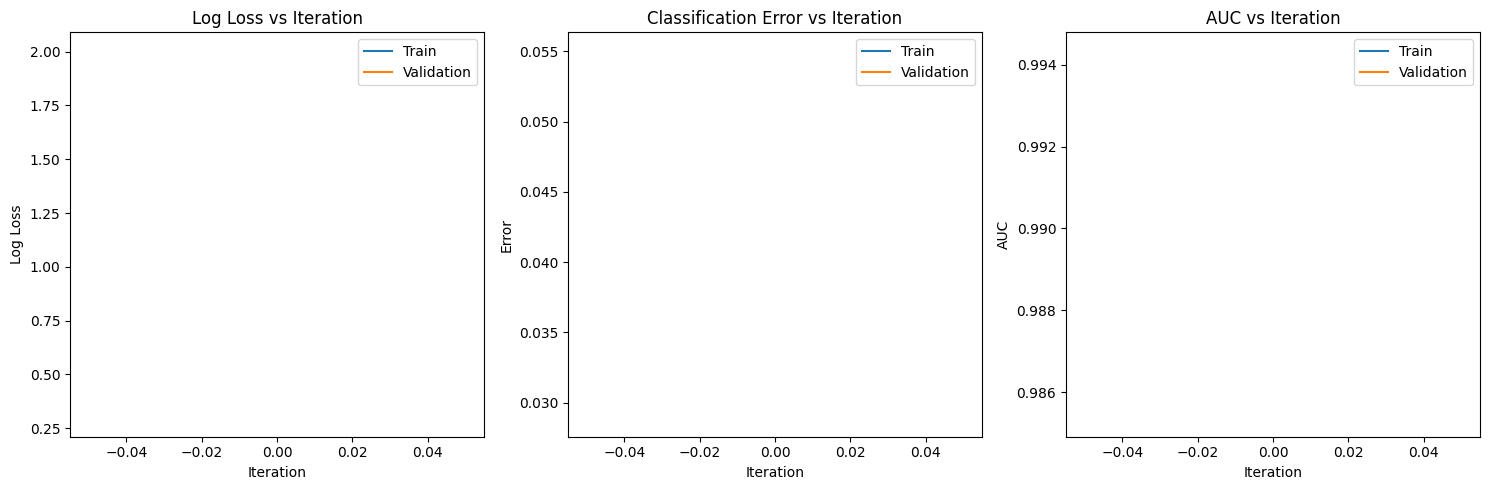

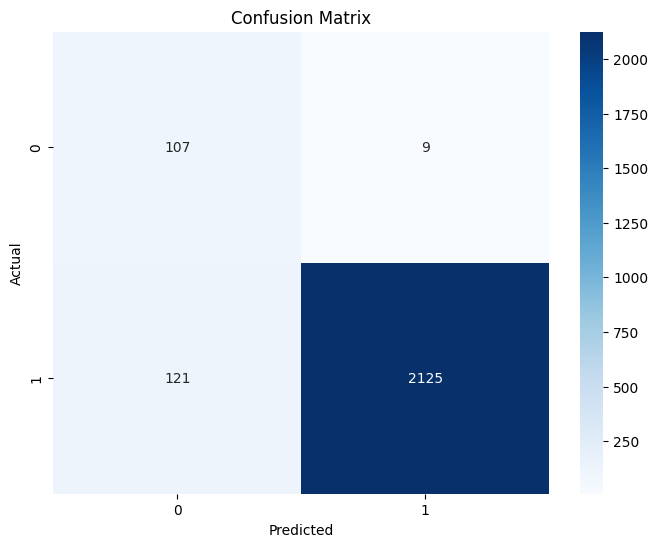

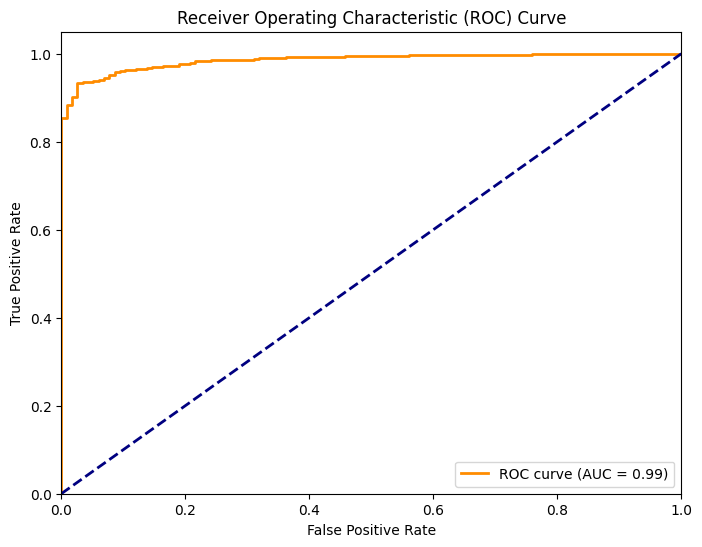


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.92      0.62       116
           1       1.00      0.95      0.97      2246

    accuracy                           0.94      2362
   macro avg       0.73      0.93      0.80      2362
weighted avg       0.97      0.94      0.95      2362



In [23]:
svm_model, svm_results = train_and_evaluate_model(embeddings, y, model_type='svm')

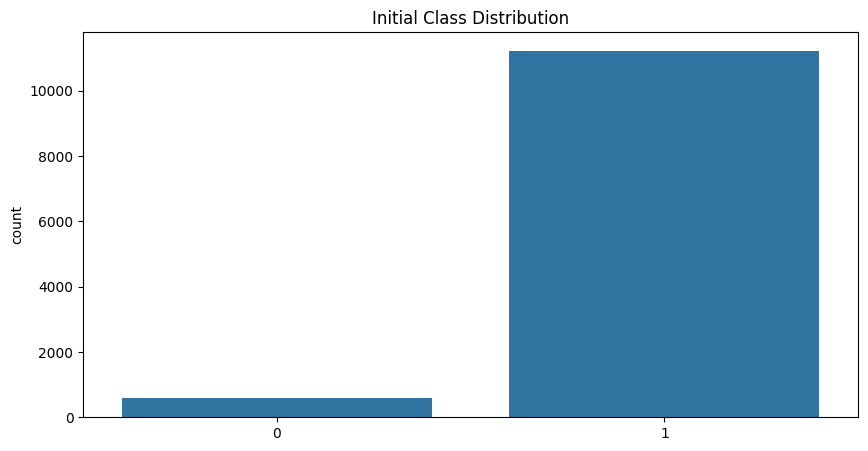

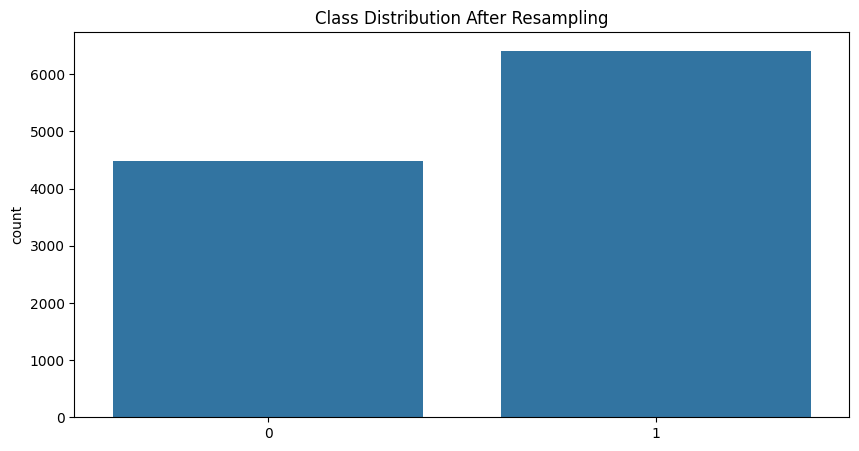

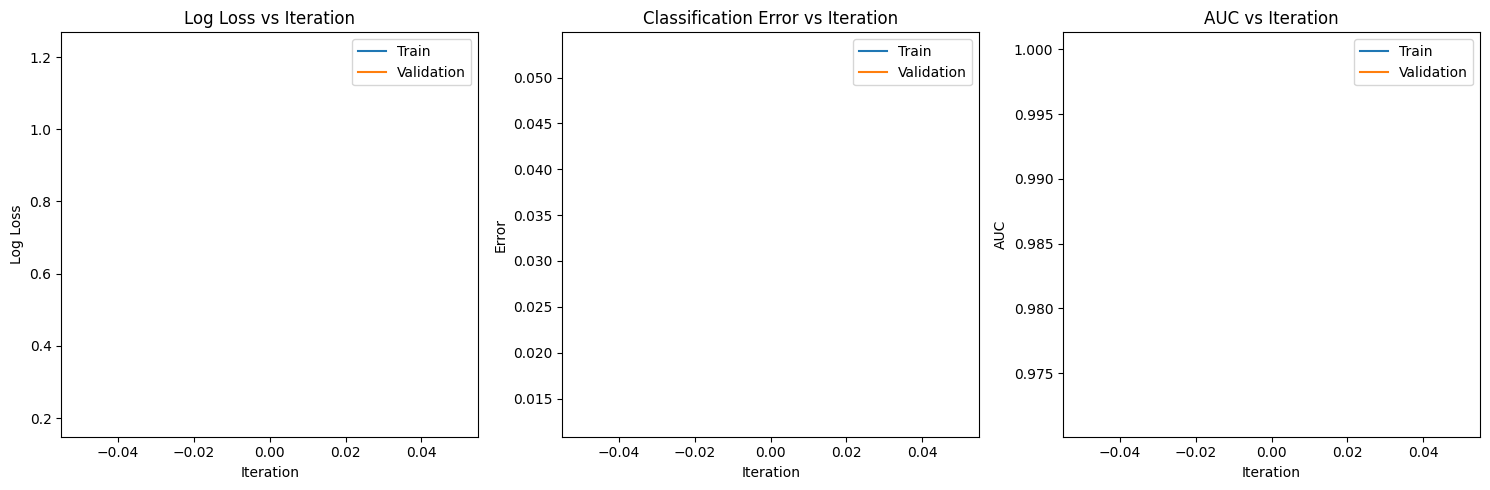

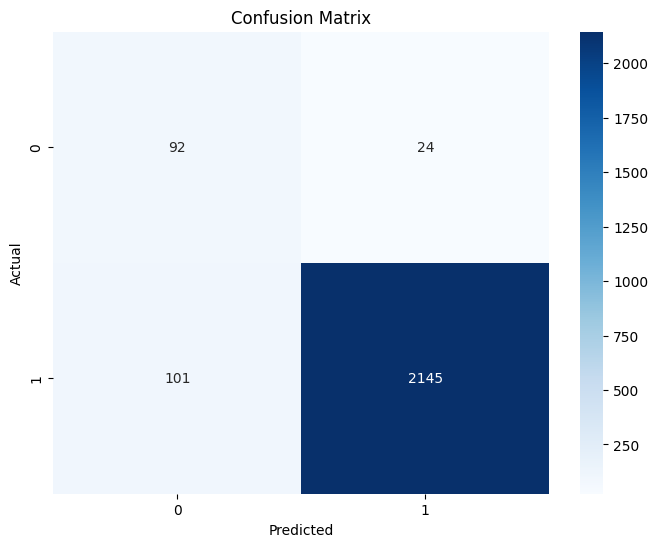

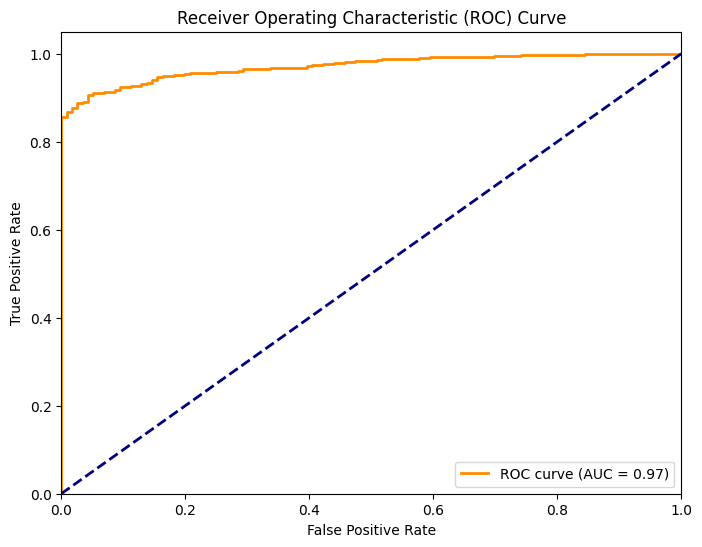


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.79      0.60       116
           1       0.99      0.96      0.97      2246

    accuracy                           0.95      2362
   macro avg       0.73      0.87      0.78      2362
weighted avg       0.96      0.95      0.95      2362



In [24]:
rf_model, rf_results = train_and_evaluate_model(embeddings, y, model_type='rf')

In [37]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert data to tensors

X_train, X_test, y_train, y_test = train_test_split(
        embeddings, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

# Convert to dense format if using sparse matrices
if hasattr(X_train, 'toarray'):
    X_train = X_train.toarray()
    X_test = X_test.toarray()

# Apply resampling
resampling = create_resampling_pipeline()
X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)

train_data = TensorDataset(torch.tensor(X_train_resampled, dtype=torch.float32), torch.tensor(y_train_resampled))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))

In [38]:
from torch.utils.data import RandomSampler, SequentialSampler
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
test_loader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

In [39]:

# Define the model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_dim = embeddings.shape[1]
model = SentimentClassifier(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def train_and_plot_losses(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    # Lists to store losses
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            batch_inputs, batch_labels = batch
            batch_labels = batch_labels.type(torch.FloatTensor).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation/Test phase
        model.eval()
        total_test_loss = 0

        with torch.no_grad():
            for batch in test_loader:
                batch_inputs, batch_labels = batch
                batch_labels = batch_labels.type(torch.FloatTensor).unsqueeze(1)

                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels)
                total_test_loss += loss.item()

        # Average test loss for the epoch
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.title('Training and Test Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, test_losses

Epoch 1/100, Training Loss: 0.5886, Test Loss: 0.4091
Epoch 2/100, Training Loss: 0.4108, Test Loss: 0.3169
Epoch 3/100, Training Loss: 0.3127, Test Loss: 0.2528
Epoch 4/100, Training Loss: 0.2590, Test Loss: 0.2380
Epoch 5/100, Training Loss: 0.2255, Test Loss: 0.2090
Epoch 6/100, Training Loss: 0.2034, Test Loss: 0.1848
Epoch 7/100, Training Loss: 0.1867, Test Loss: 0.1702
Epoch 8/100, Training Loss: 0.1744, Test Loss: 0.1605
Epoch 9/100, Training Loss: 0.1651, Test Loss: 0.1688
Epoch 10/100, Training Loss: 0.1585, Test Loss: 0.1573
Epoch 11/100, Training Loss: 0.1518, Test Loss: 0.1507
Epoch 12/100, Training Loss: 0.1458, Test Loss: 0.1498
Epoch 13/100, Training Loss: 0.1426, Test Loss: 0.1453
Epoch 14/100, Training Loss: 0.1383, Test Loss: 0.1308
Epoch 15/100, Training Loss: 0.1351, Test Loss: 0.1363
Epoch 16/100, Training Loss: 0.1316, Test Loss: 0.1347
Epoch 17/100, Training Loss: 0.1293, Test Loss: 0.1281
Epoch 18/100, Training Loss: 0.1266, Test Loss: 0.1272
Epoch 19/100, Train

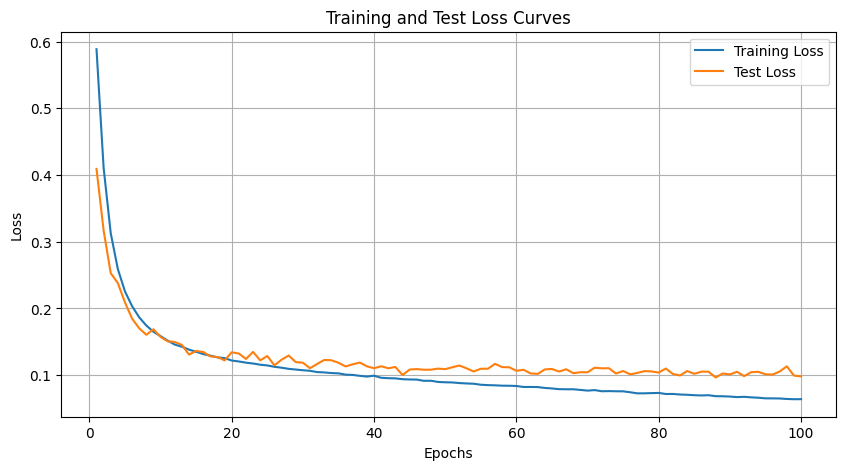

In [40]:
train_losses, test_losses = train_and_plot_losses(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=100
)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch_inputs, batch_labels = batch
        outputs = model(batch_inputs)
        preds = (outputs >= 0.5).int()
        predictions.extend(preds.squeeze().tolist())
        true_labels.extend(batch_labels.tolist())

print("Deep Learning Model Performance with BERT Embeddings:")
print(classification_report(true_labels, predictions))


Deep Learning Model Performance with BERT Embeddings:
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       116
           1       0.99      0.97      0.98      2246

    accuracy                           0.96      2362
   macro avg       0.78      0.92      0.84      2362
weighted avg       0.97      0.96      0.97      2362

